In [5]:
DISPLAY_ONLY = True

In [1]:
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from dataset_utils import mkdir_if_missing
from PIL import Image
from skimage import io
from tqdm import tqdm

import json
import pprint


## Converting wisdom sim dataset to cluttered omniglot format

In [2]:
DATASET_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/wisdom-sim-block-npy"
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net/fold_0004"
mkdir_if_missing(OUT_DIR)
mkdir_if_missing(os.path.join(OUT_DIR, "train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-one-shot"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-one-shot"))

# Dataset size
NUM_IMS = 10

# input image size
IM_HEIGHT = 384
IM_WIDTH = 512

# 1:3 ratio between im_size and tar_size
IM_SIZE = 384
TAR_SIZE = 128

# Image distortion
ANGLE = 0
SHEAR = 0

In [6]:
def rot_x(phi, theta, ptx, pty):
    return np.cos(phi+theta)*ptx + np.sin(phi-theta)*pty


def rot_y(phi, theta, ptx, pty):
    return -np.sin(phi+theta)*ptx + np.cos(phi-theta)*pty


def prepare_img(img, angle=100, shear=2.5, scale=2):
    # Apply affine transformations and scale characters for data augmentation
    phi = np.radians(np.random.uniform(-angle, angle))
    theta = np.radians(np.random.uniform(-shear, shear))
    a = scale**np.random.uniform(-1, 1)
    b = scale**np.random.uniform(-1, 1)
    (x, y) = img.shape
    x = a * x
    y = b * y
    xextremes = [rot_x(phi, theta, 0, 0), rot_x(phi, theta, 0, y), rot_x(phi, theta, x, 0), rot_x(phi, theta, x, y)]
    yextremes = [rot_y(phi, theta, 0, 0), rot_y(phi, theta, 0, y), rot_y(phi, theta, x, 0), rot_y(phi, theta, x, y)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)

    aff_bas = np.array([[a*np.cos(phi+theta), b*np.sin(phi-theta), -mnx], [-a*np.sin(phi+theta), b*np.cos(phi-theta), -mny], [0, 0, 1]])
    aff_prm = np.linalg.inv(aff_bas)
    pil_img = Image.fromarray(img)
    pil_img = pil_img.transform((int(mxx - mnx),int(mxy - mny)),
                                    method=Image.AFFINE,
                                    data=np.ndarray.flatten(aff_prm[0:2, :]))
    pil_img = pil_img.resize((int(TAR_SIZE * (mxx - mnx) / 100), int(TAR_SIZE * (mxy - mny) / 100)))

    return np.array(pil_img)


def bbox(im):
    # get bounding box coordinates
    rows = np.any(im, axis=1)
    cols = np.any(im, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def make_target(modal_mask, angle=0, shear=0, scale=1):
    # make target image by cropping
    # formula: use the bigger bounding box length plus half of the smaller
    # margin between the edge of the image and the bbox
    
    # transformed_mask = prepare_img(modal_mask, angle, shear, scale)
    transformed_mask = modal_mask
    """plt.figure()
    plt.title("{}-{}".format(im_idx, mask_idx), {"fontsize": 20})
    plt.imshow(transformed_mask)"""
    top, bot, left, right = bbox(transformed_mask)
    if bot - top > right - left:
        right += (bot - top - (right - left)) // 2
        left -= (bot - top - (right - left)) // 2
    else:
        bot += (right - left - (bot - top)) // 2
        top -= (right - left - (bot - top)) // 2
    margin = min(top, left, transformed_mask.shape[0] - bot, transformed_mask.shape[1] - right)

    target = cv2.resize(
        transformed_mask[max(0, top - margin):min(transformed_mask.shape[0], bot + margin),
                         max(0, left - margin):min(transformed_mask.shape[1], right + margin)],
        (TAR_SIZE, TAR_SIZE),
        interpolation=cv2.INTER_NEAREST)
    # in the case we have a very zoomed in object, fix that
    if margin < 20:
        padded_target = np.zeros((target.shape[0] + 40, target.shape[1] + 40))
        padded_target[20:padded_target.shape[0] - 20, 20:padded_target.shape[1] - 20] = target
        return cv2.resize(padded_target, (TAR_SIZE, TAR_SIZE), interpolation=cv2.INTER_NEAREST)
    return target
        

def resize_scene(im):
    if len(im.shape) == 2:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0)), mode="constant")
    elif len(im.shape) == 3:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0), (0, 0)), mode="constant")
    else:
        raise Exception("image dimensions not valid for scene/ground truth, shape: {}".format(im.shape))
    return cv2.resize(
        im,
        (IM_SIZE, IM_SIZE),
        interpolation=cv2.INTER_NEAREST)

  0%|          | 0/10 [00:00<?, ?it/s]

0-0
0-1
0-2
0-3
0-4
0-5


/home/andrewyli/oss/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 10%|█         | 1/10 [00:00<00:04,  2.02it/s]

1-0
1-1
1-2
1-3
1-4
1-5


 20%|██        | 2/10 [00:01<00:04,  1.99it/s]

2-0
2-1
2-2
2-3
2-4
2-5


 30%|███       | 3/10 [00:01<00:03,  2.05it/s]

3-0
3-1
3-2
3-3
3-4
3-5


 40%|████      | 4/10 [00:01<00:02,  2.01it/s]

4-0
4-1
4-2
4-3
4-4


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

4-5
5-0
5-1
5-2
5-3
5-4
5-5


 60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

6-0
6-1
6-2
6-3
6-4
6-5


 70%|███████   | 7/10 [00:03<00:01,  1.74it/s]

7-0
7-1
7-2
7-3
7-4
7-5


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

8-0
8-1
8-2
8-3
8-4
8-5


 90%|█████████ | 9/10 [00:04<00:00,  1.79it/s]

9-0
9-1
9-2
9-3


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

9-4
9-5


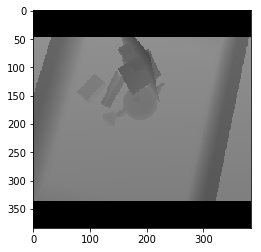

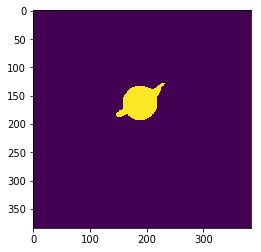

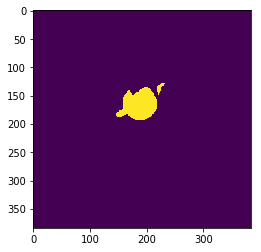

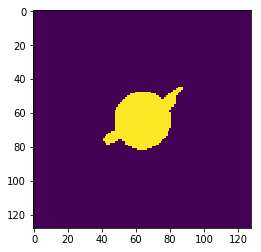

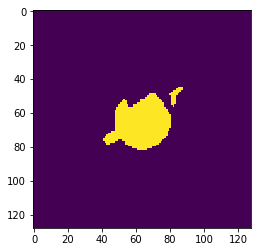

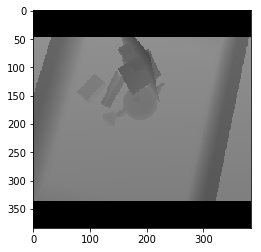

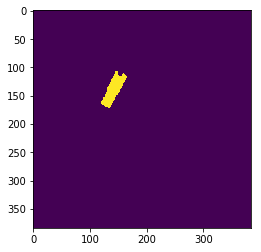

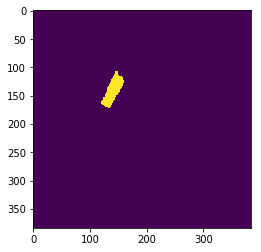

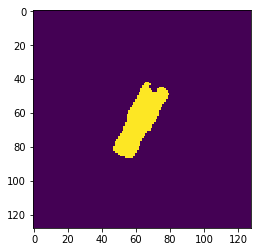

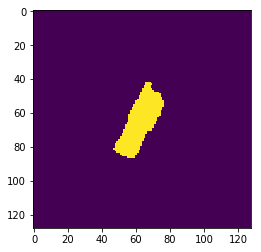

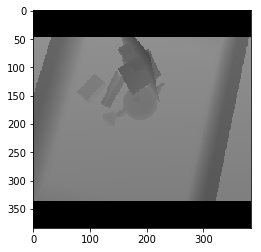

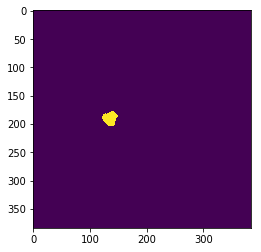

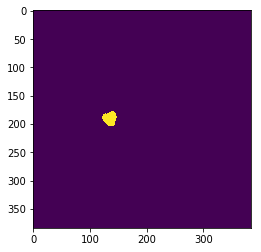

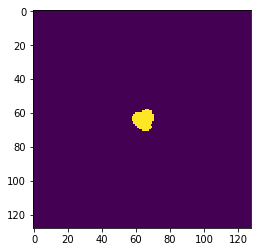

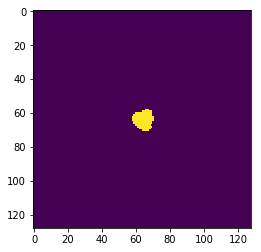

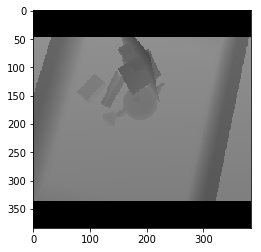

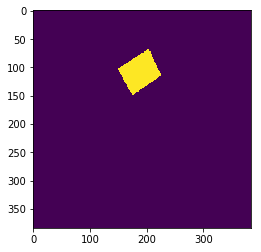

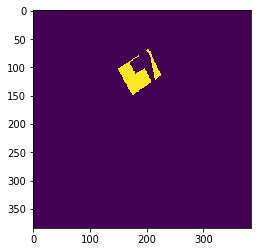

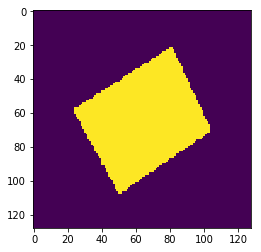

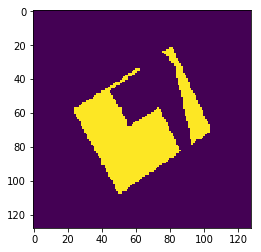

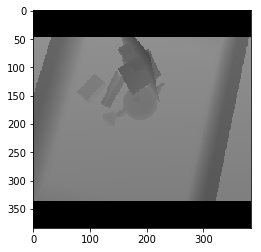

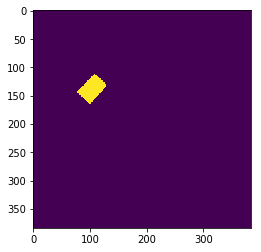

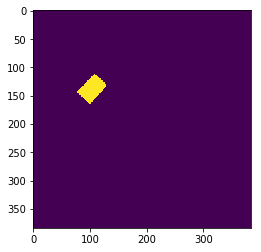

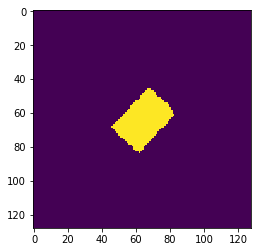

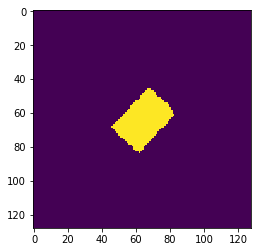

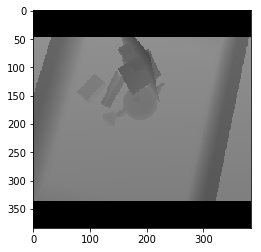

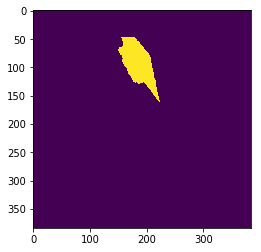

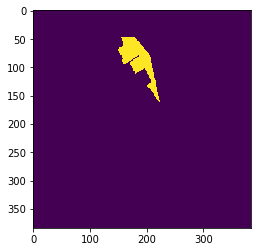

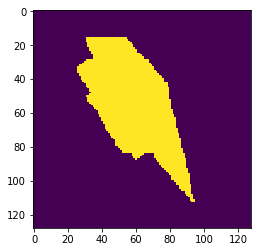

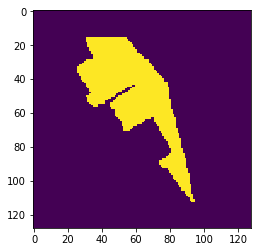

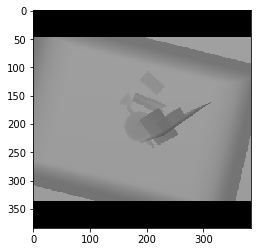

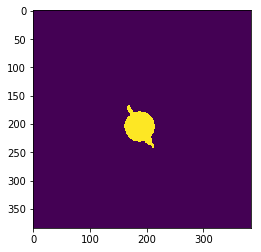

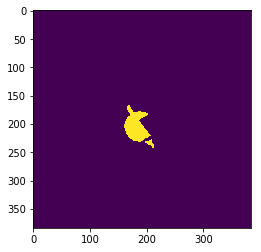

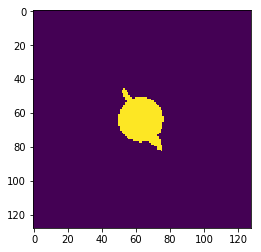

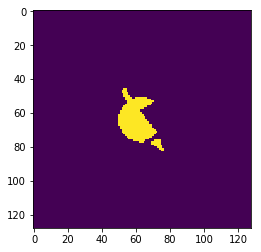

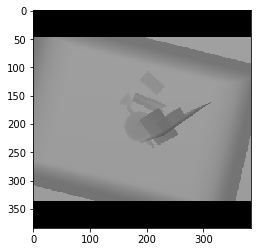

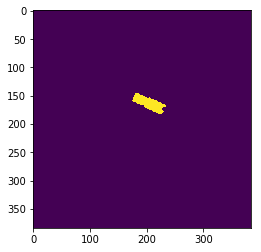

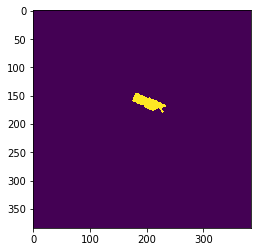

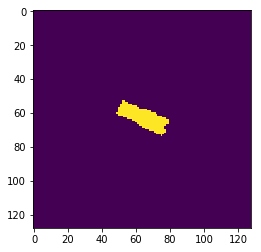

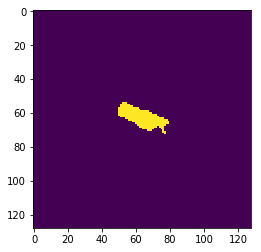

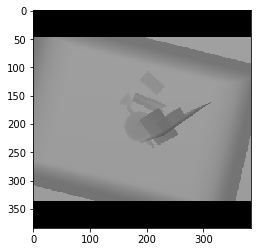

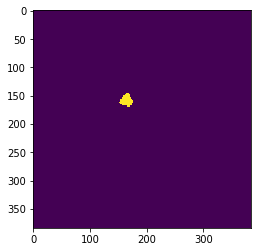

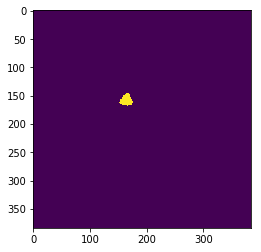

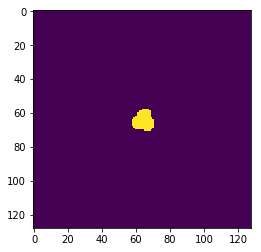

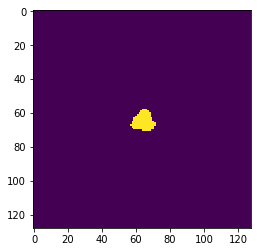

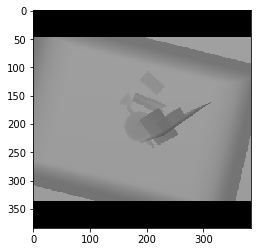

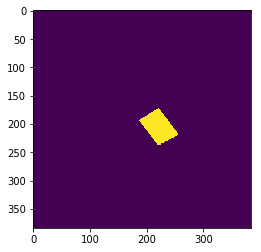

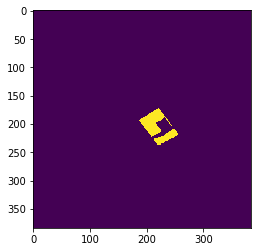

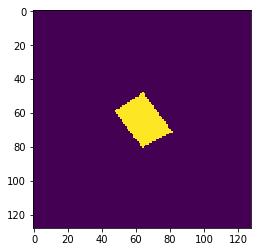

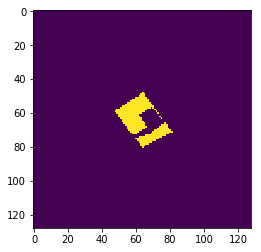

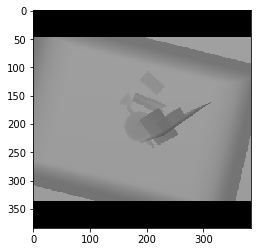

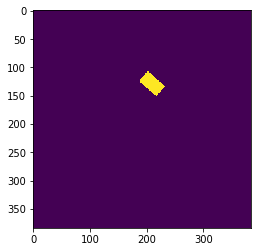

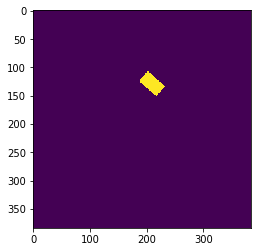

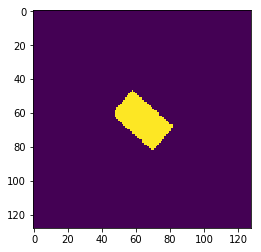

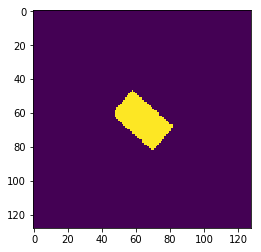

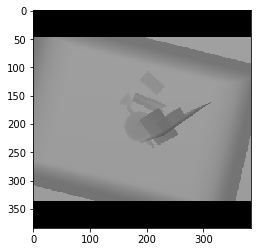

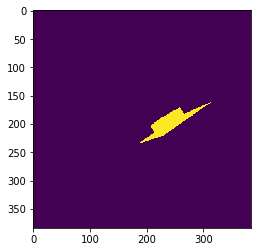

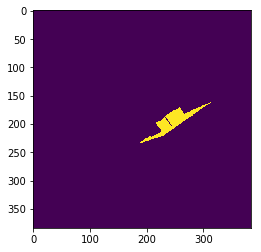

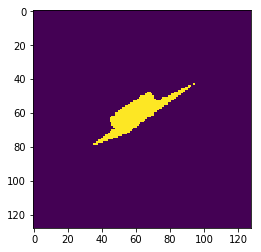

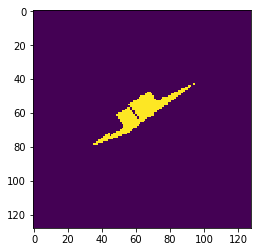

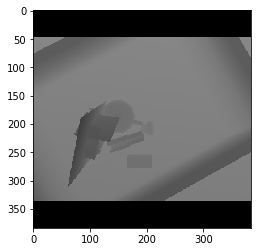

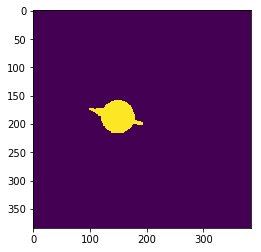

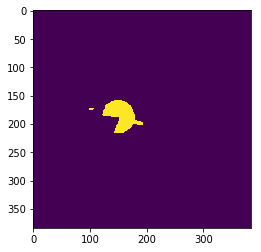

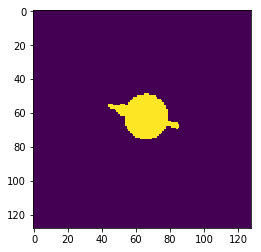

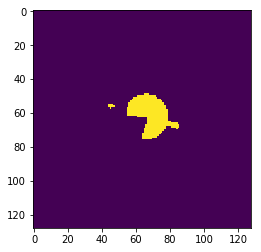

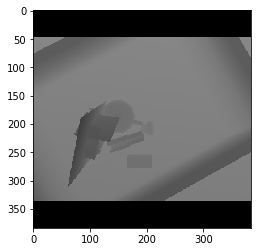

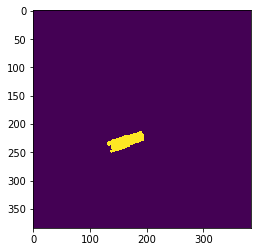

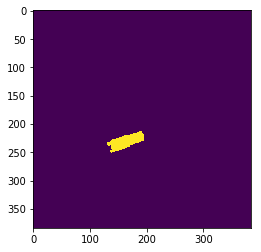

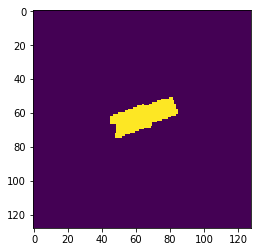

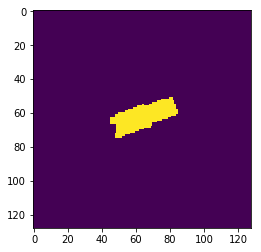

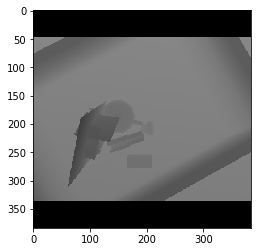

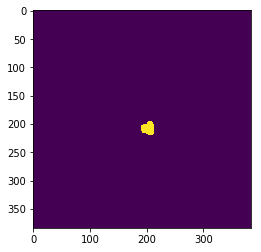

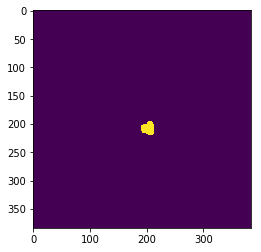

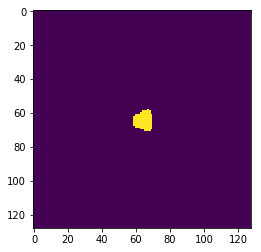

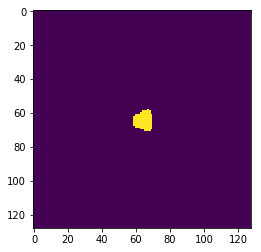

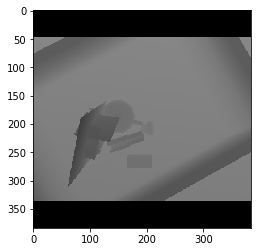

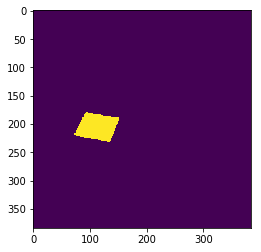

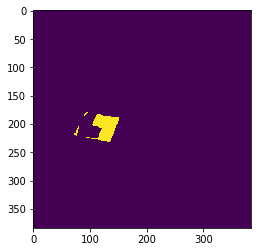

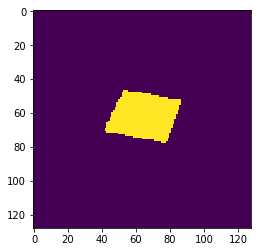

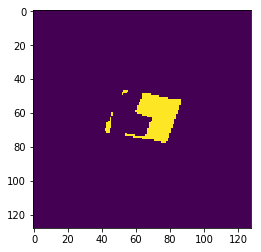

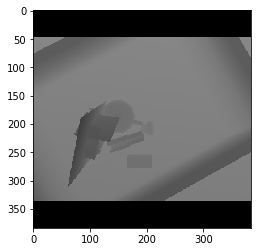

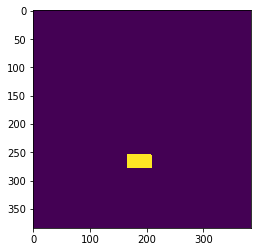

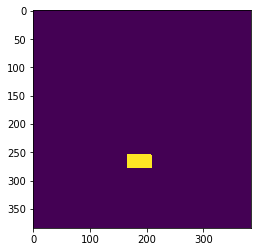

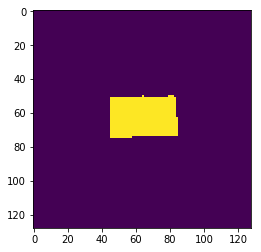

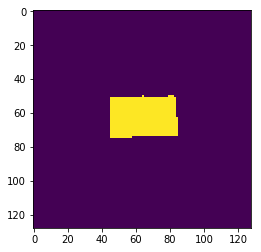

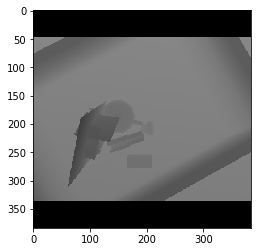

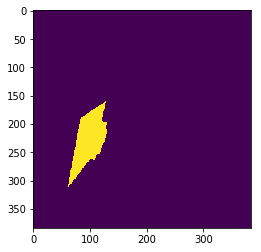

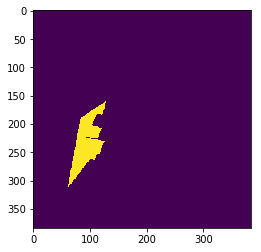

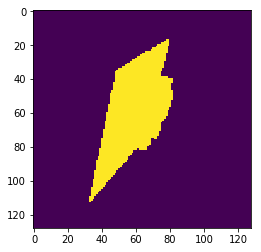

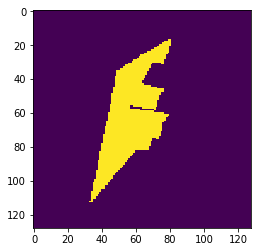

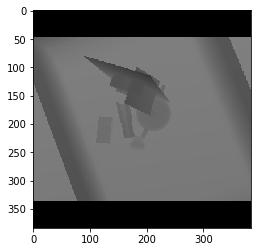

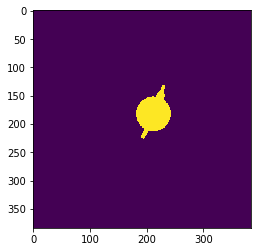

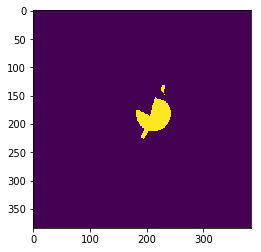

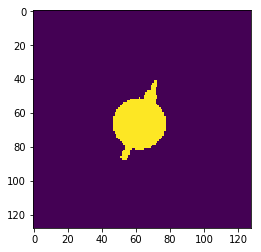

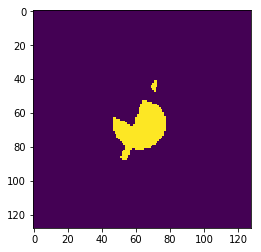

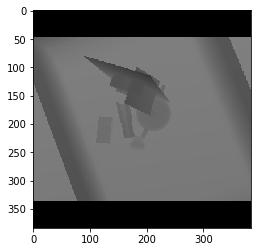

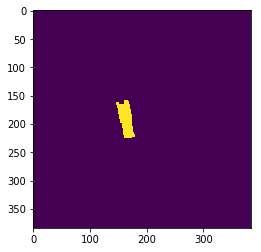

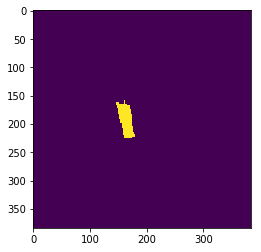

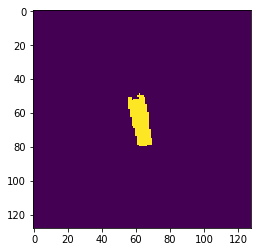

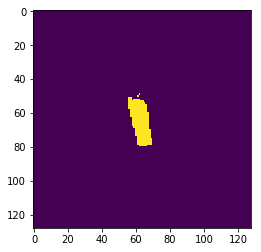

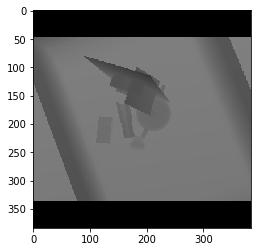

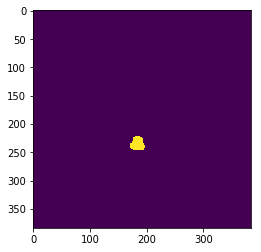

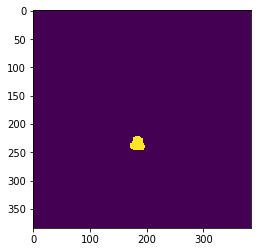

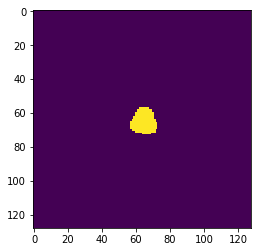

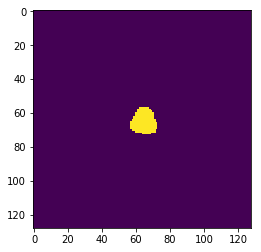

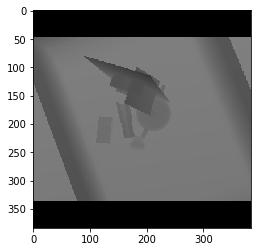

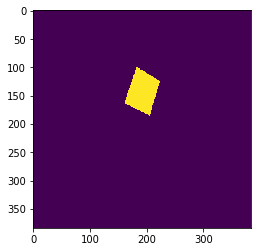

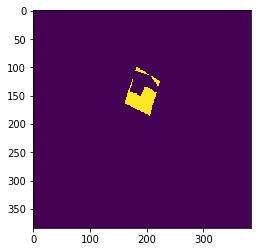

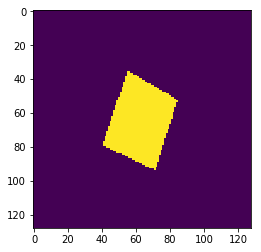

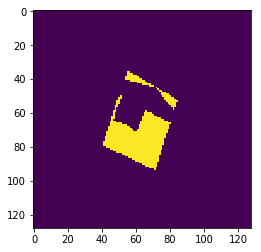

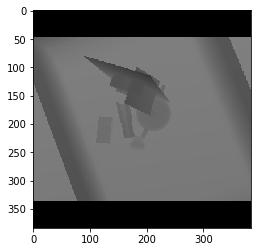

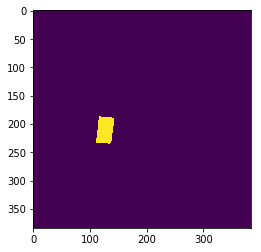

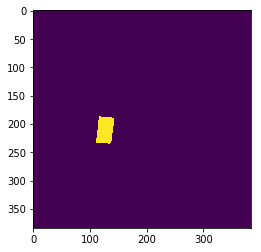

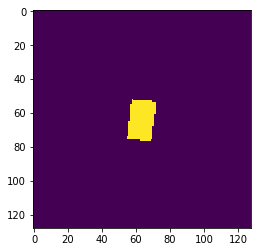

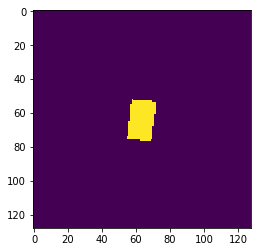

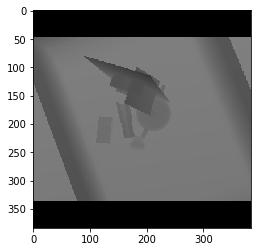

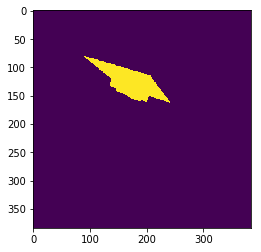

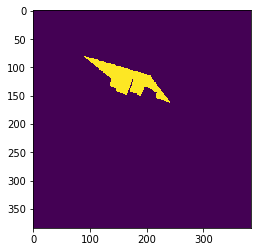

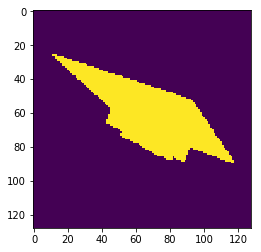

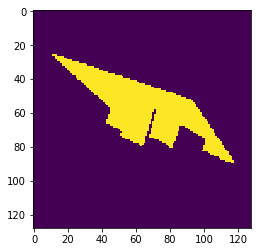

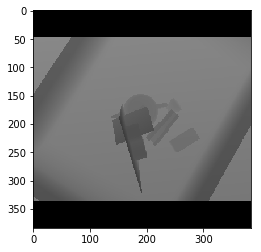

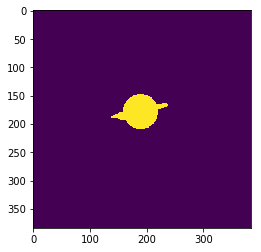

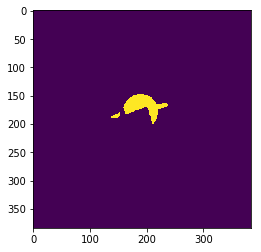

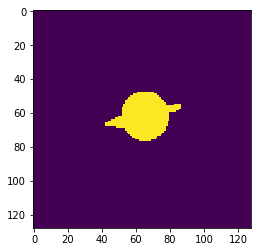

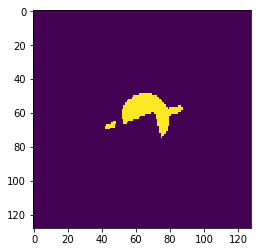

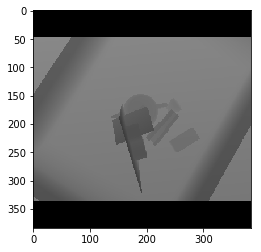

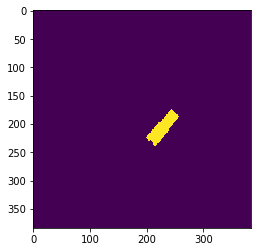

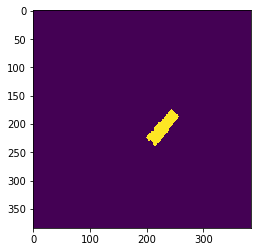

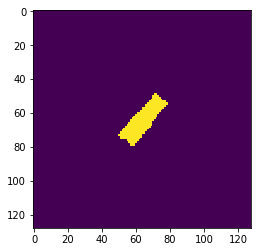

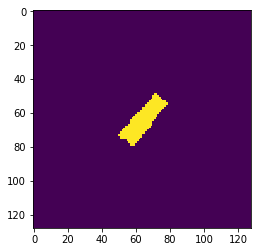

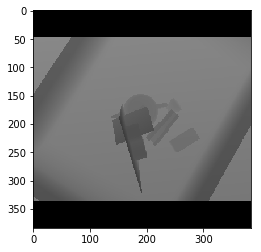

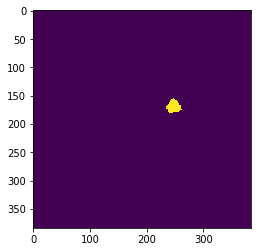

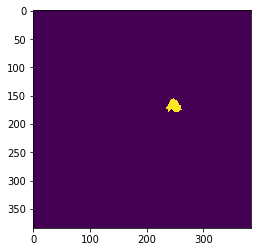

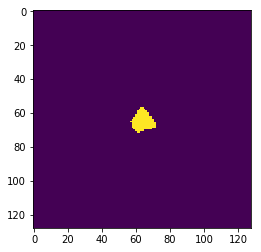

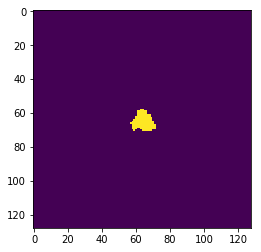

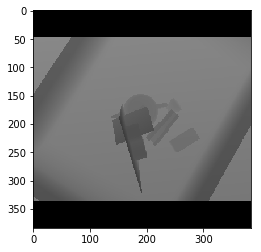

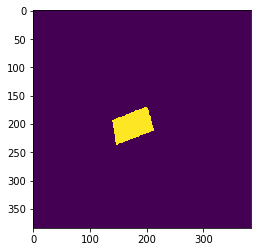

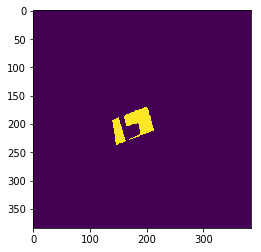

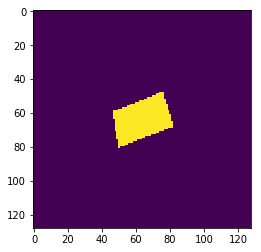

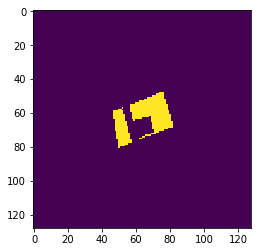

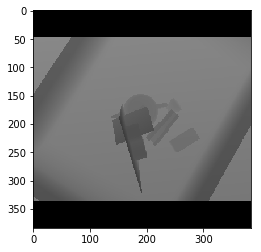

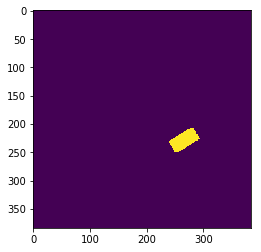

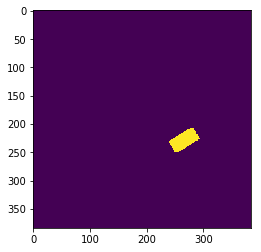

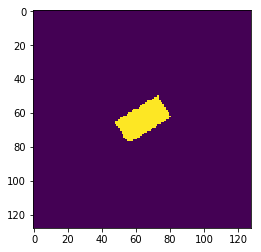

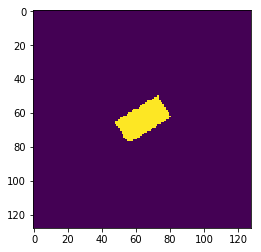

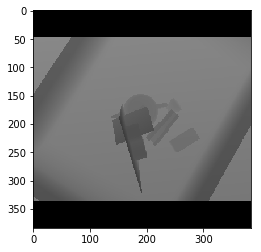

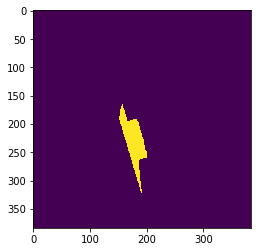

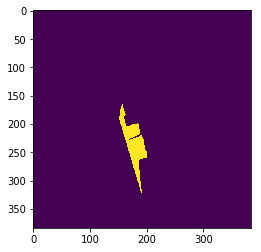

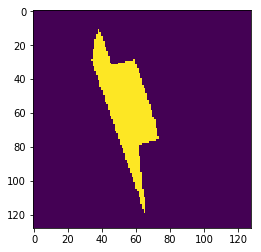

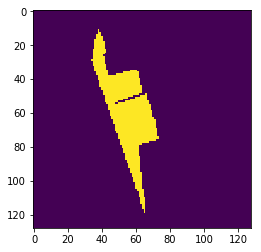

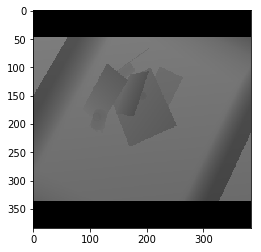

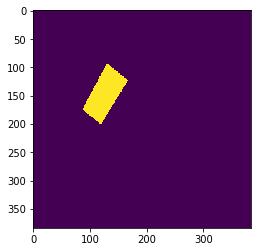

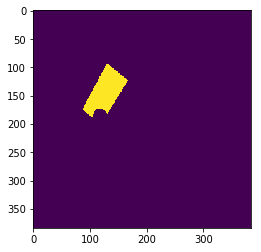

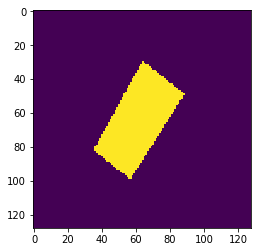

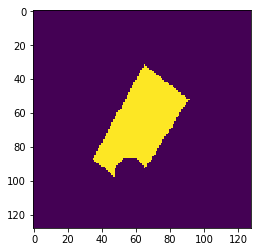

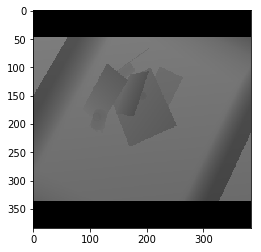

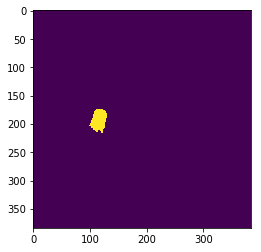

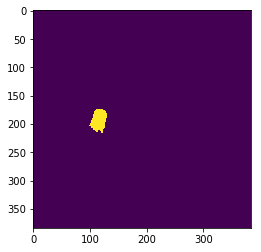

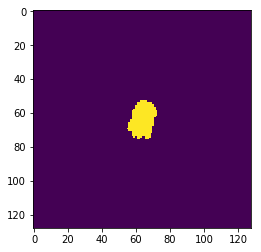

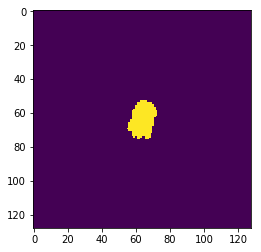

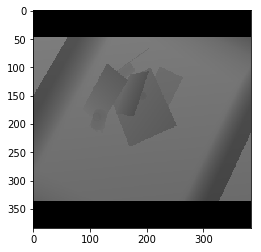

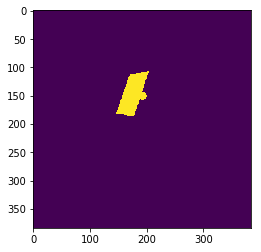

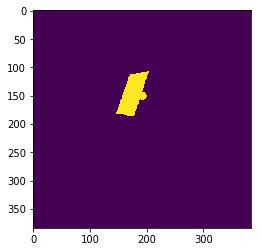

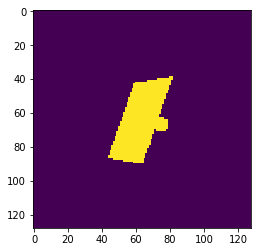

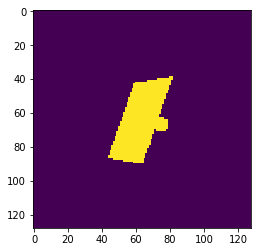

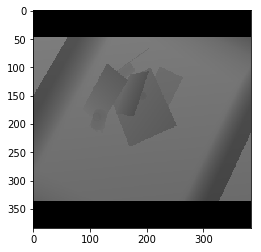

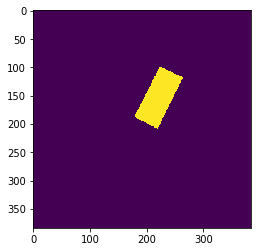

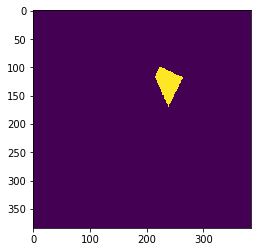

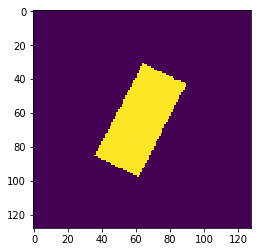

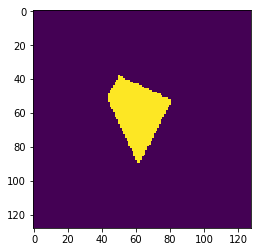

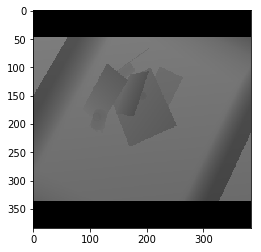

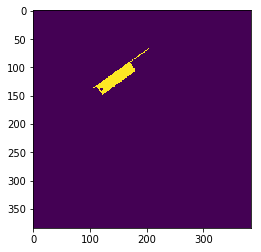

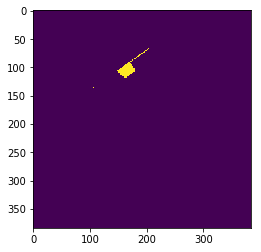

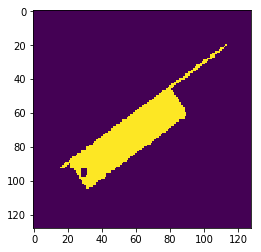

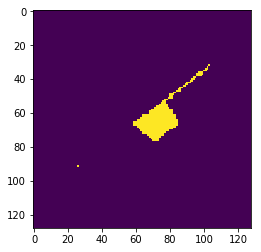

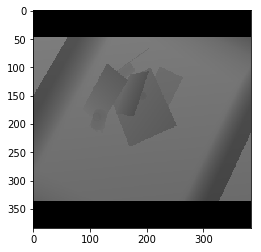

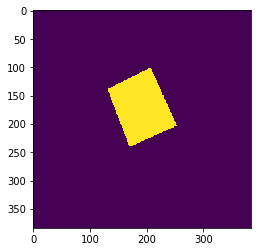

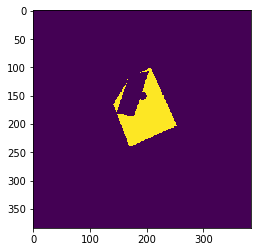

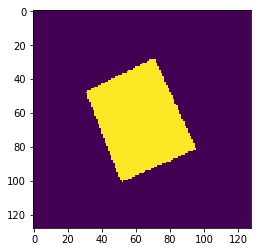

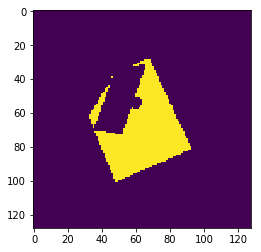

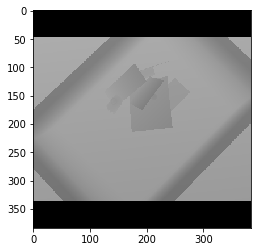

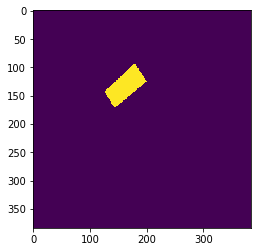

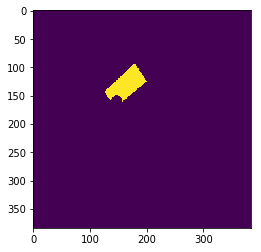

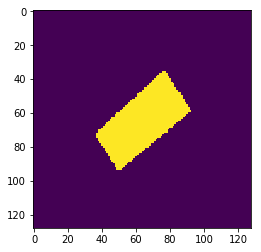

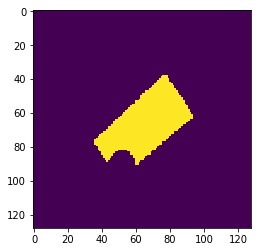

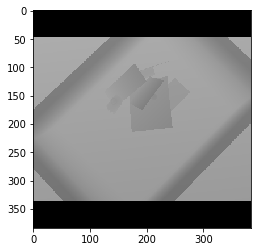

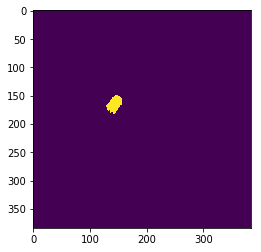

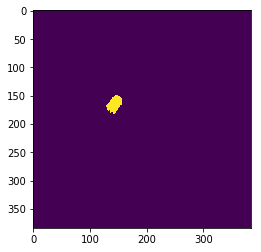

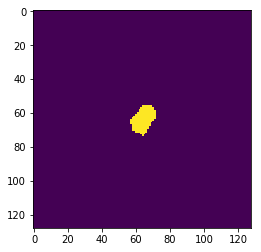

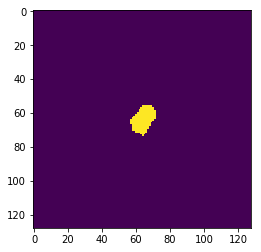

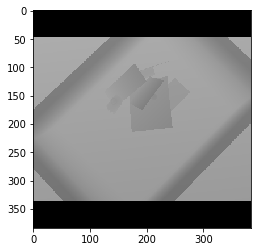

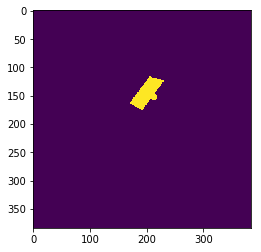

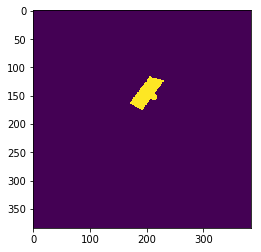

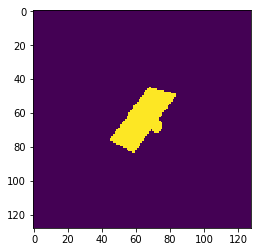

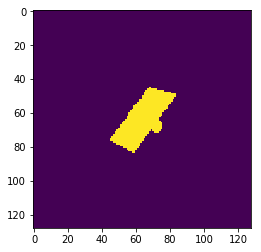

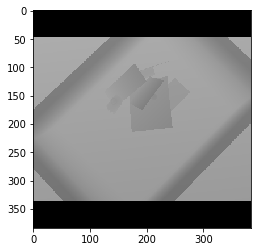

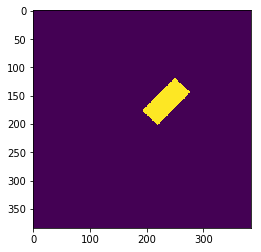

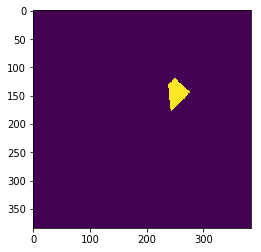

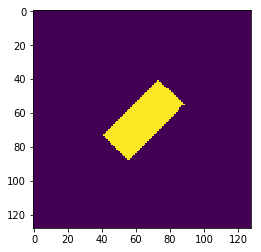

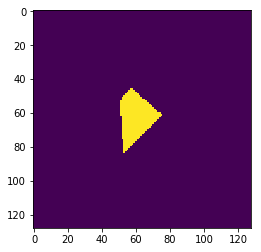

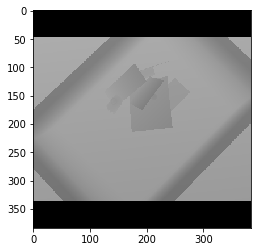

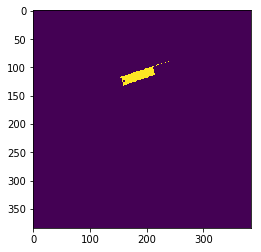

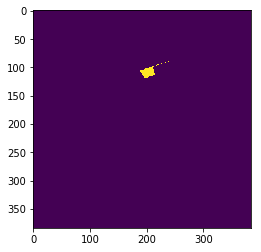

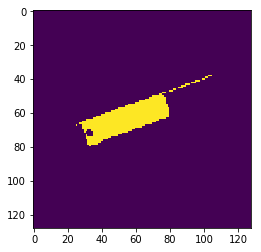

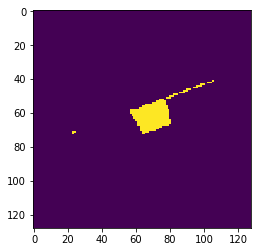

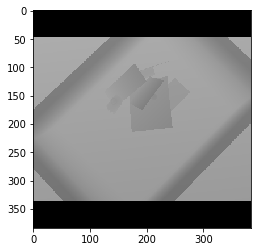

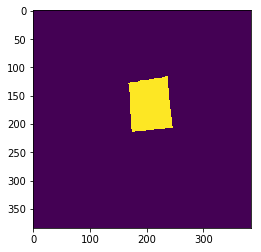

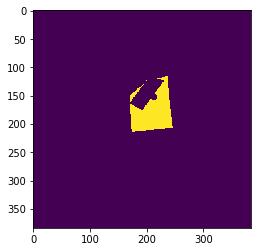

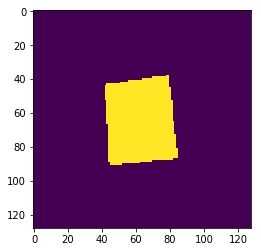

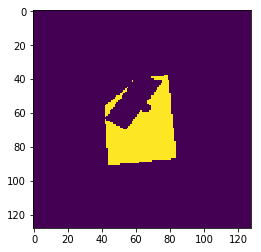

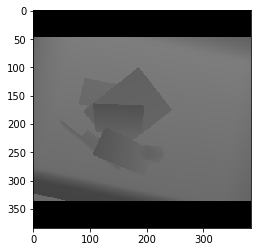

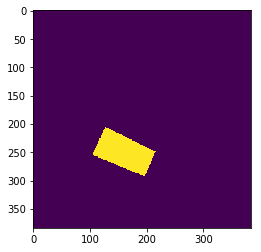

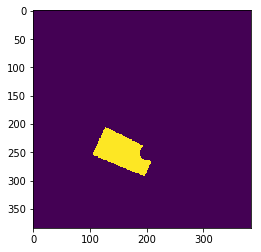

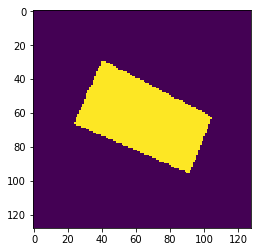

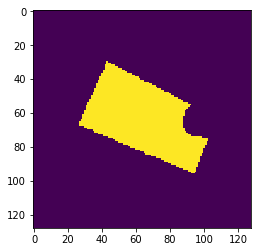

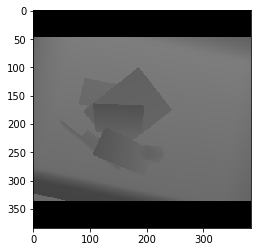

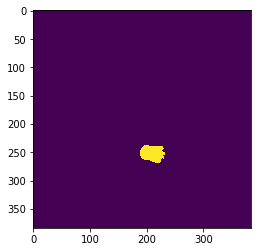

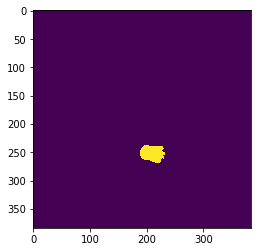

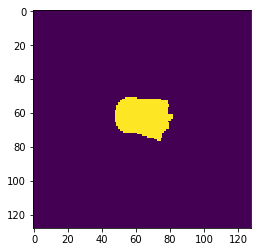

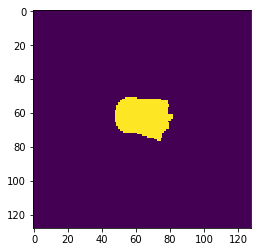

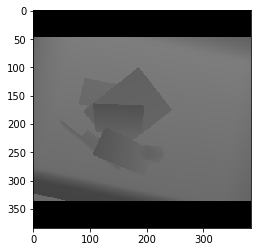

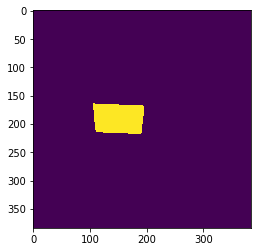

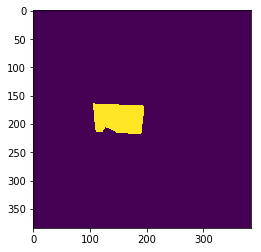

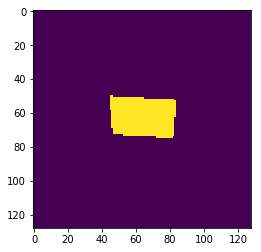

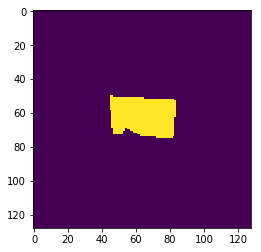

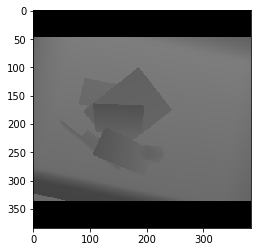

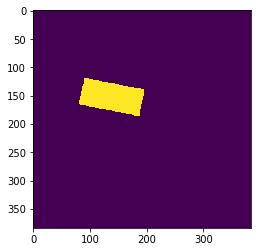

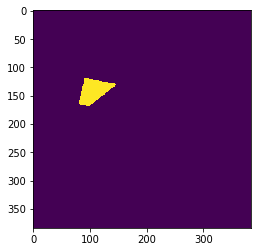

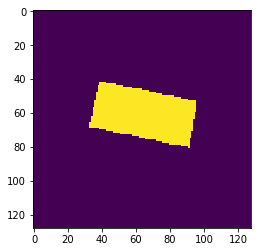

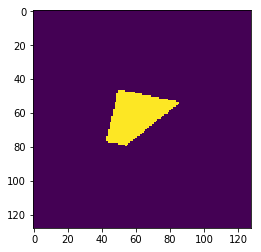

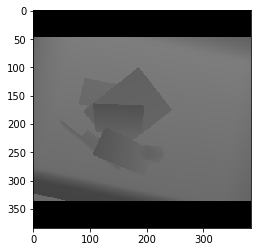

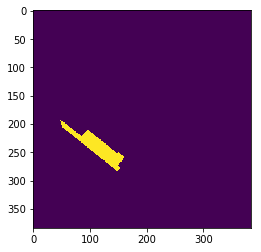

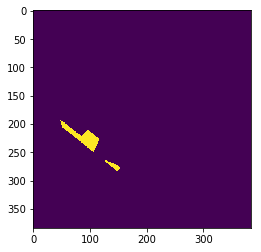

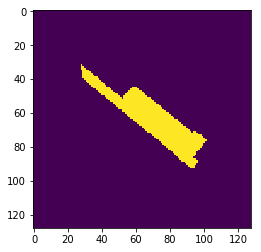

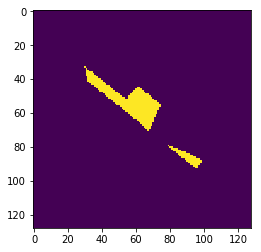

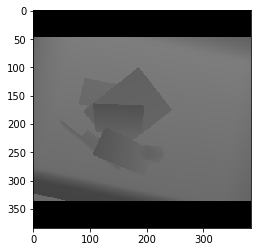

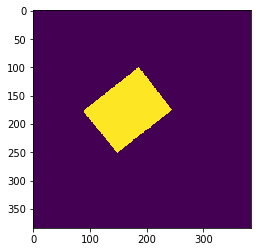

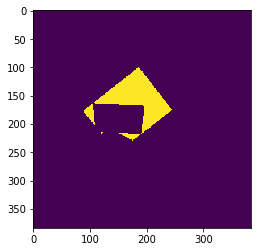

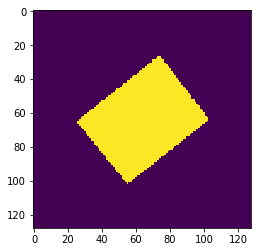

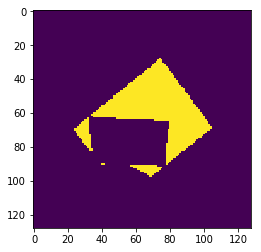

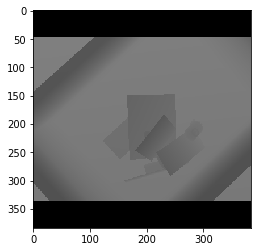

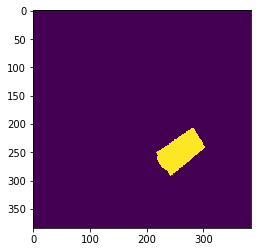

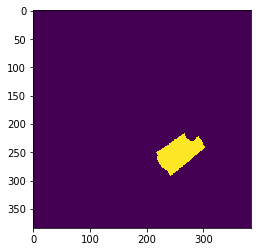

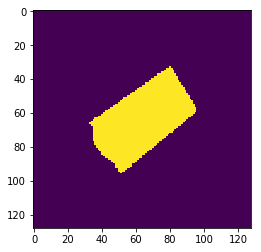

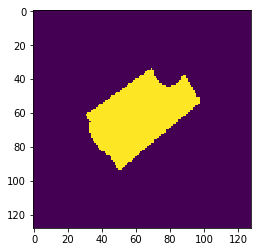

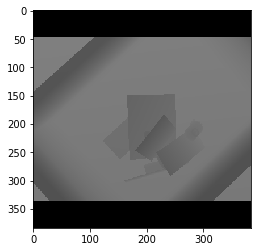

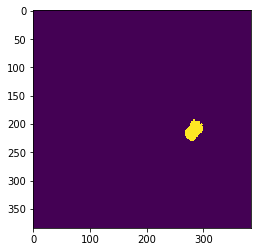

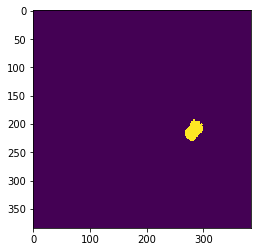

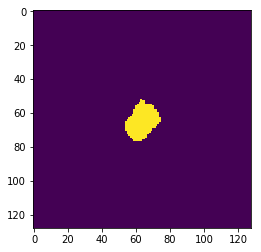

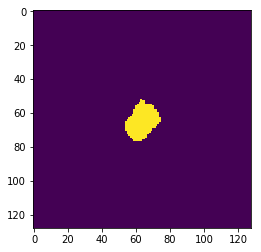

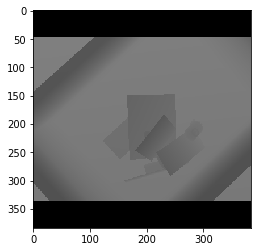

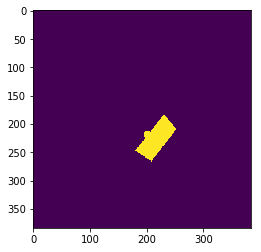

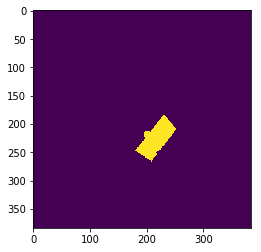

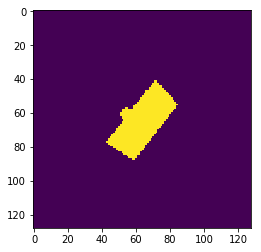

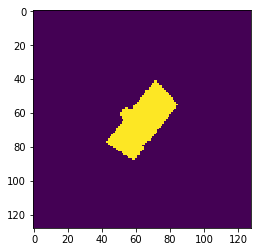

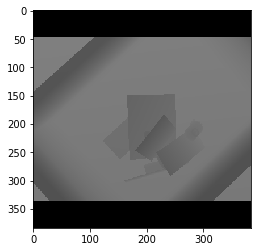

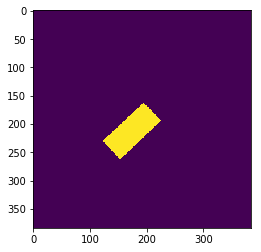

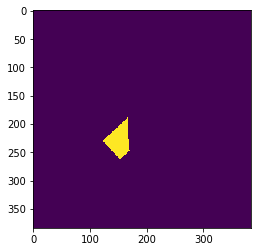

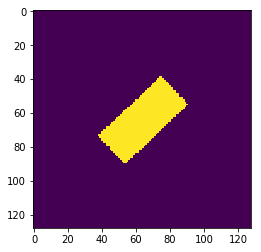

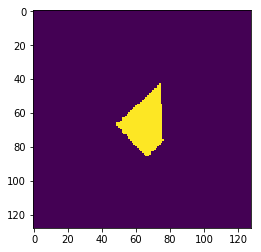

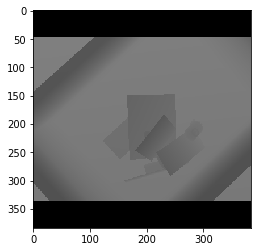

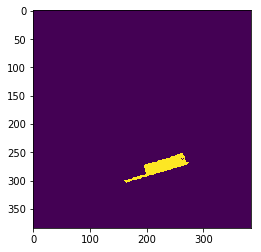

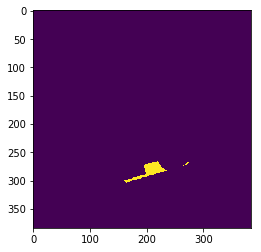

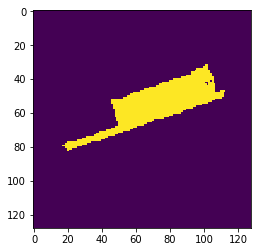

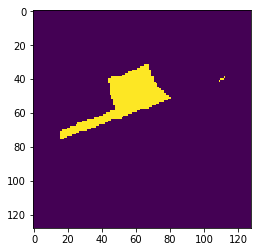

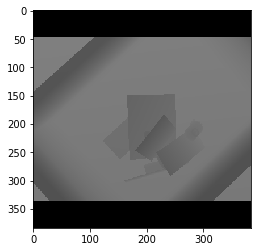

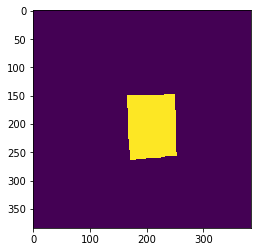

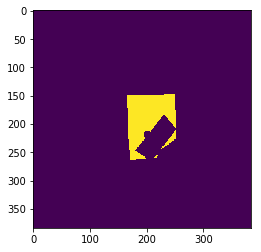

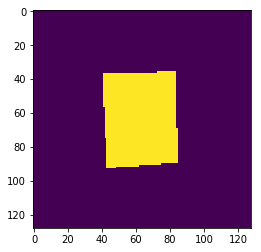

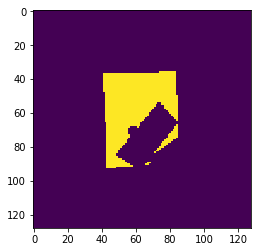

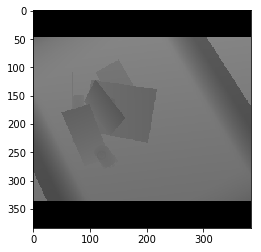

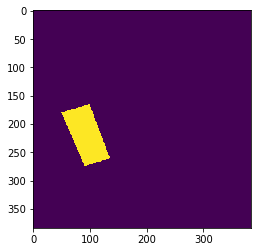

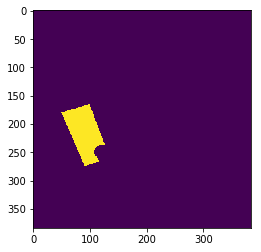

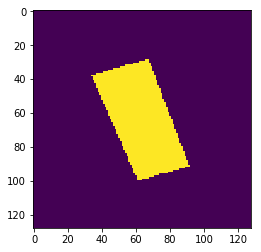

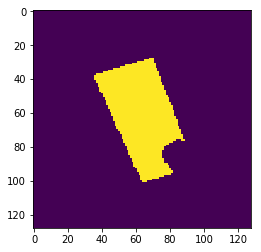

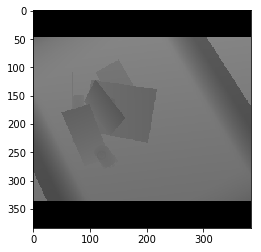

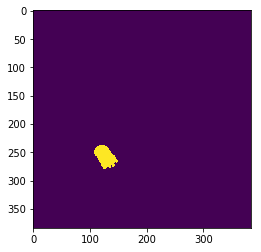

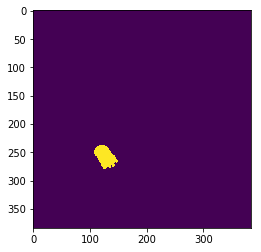

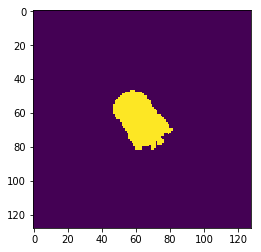

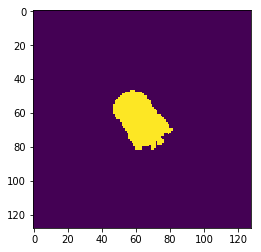

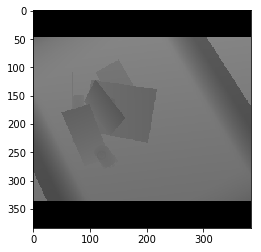

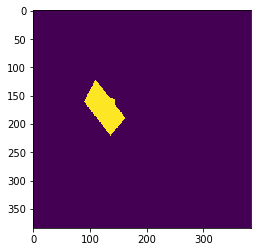

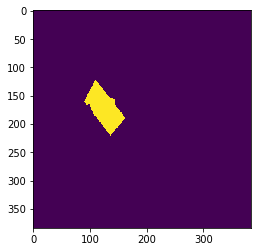

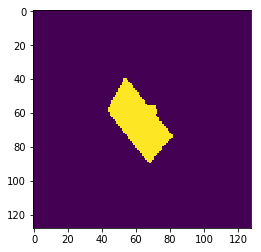

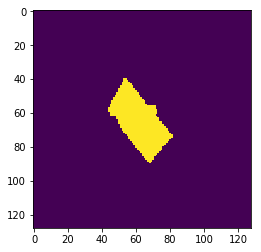

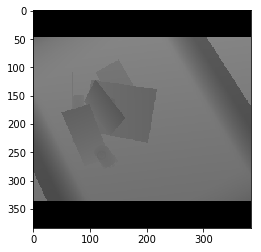

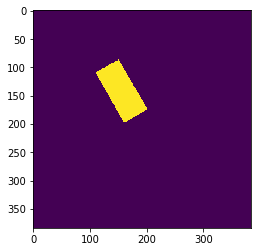

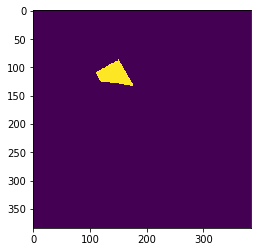

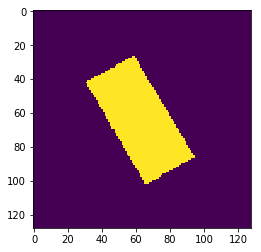

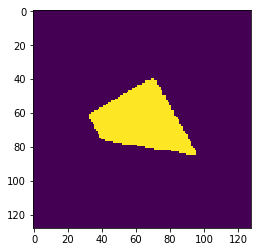

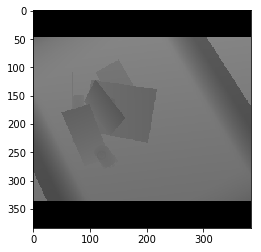

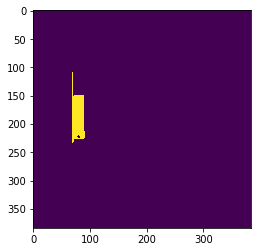

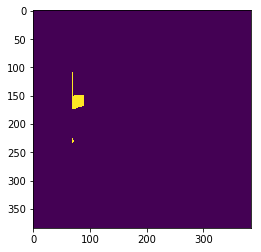

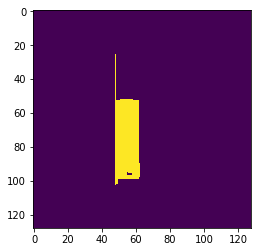

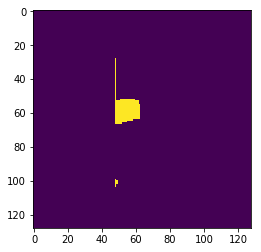

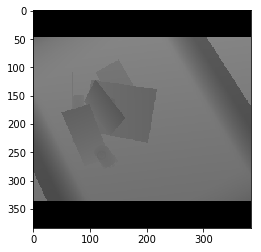

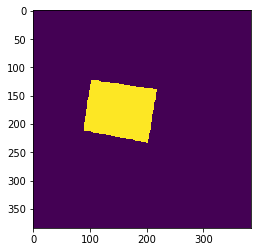

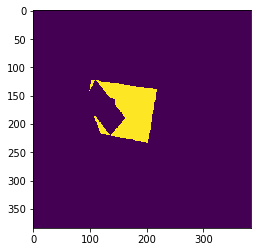

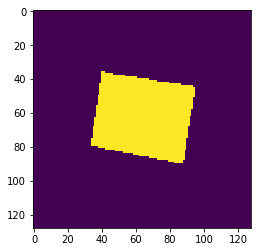

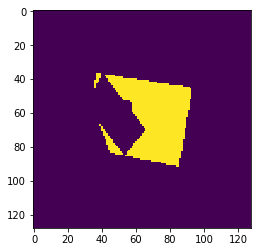

In [8]:
data_count = 0
train_indices = set(np.load(
    os.path.join(DATASET_DIR, "train_indices.npy")))
test_indices = set(np.load(
    os.path.join(DATASET_DIR, "test_indices.npy")))

train_counter = 0
test_counter = 0
test_folders = ["test-train", "test-one-shot", "val-train", "val-one-shot"]
test_counters = [0 for i in range(4)]
for im_idx in tqdm(range(NUM_IMS)):
    im_path = os.path.join(
        DATASET_DIR,
        "depth_ims",
        "image_{:06d}.png".format(im_idx))
    im = io.imread(im_path)
    im = resize_scene(im)

    for mask_idx in range(11):
        channel_name = "image_{:06d}_channel_{:03d}.png".format(im_idx, mask_idx)
        amodal_path = os.path.join(
            DATASET_DIR,
            "amodal_segmasks",
            channel_name)
        amodal_image = io.imread(amodal_path)
        amodal_mask = resize_scene(amodal_image)
        amodal_mask[amodal_mask > 0] = 1

        modal_path = os.path.join(
            DATASET_DIR,
            "modal_segmasks",
            channel_name)
        modal_image = io.imread(modal_path)
        modal_mask = resize_scene(modal_image)
        modal_mask[modal_mask > 0] = 1

        # if there is no amodal mask, object doesn't exist.
        try:
            amodal_target = make_target(amodal_image, angle=ANGLE, shear=SHEAR)
            amodal_target[amodal_target > 0] = 1

            # in case of modal->modal segmentation
            modal_target = make_target(modal_image)
            modal_target[modal_target > 0] = 1
        except:
            continue

        data_count += 1


        if DISPLAY_ONLY:
            print("{}-{}".format(im_idx, mask_idx))
            plt.figure()
            plt.imshow(im)
            plt.figure()
            plt.imshow(amodal_mask)
            plt.figure()
            plt.imshow(modal_mask)
            plt.figure()
            plt.imshow(amodal_target)
            plt.figure()
            plt.imshow(modal_target)
            continue
            
        if im_idx in train_indices:
            io.imsave(os.path.join(
                OUT_DIR,
                "train/",
                "image_{:08d}.png".format(train_counter)),
                   im)
            io.imsave(os.path.join(
                OUT_DIR,
                "train/",
                "amodal_segmentation_{:08d}.png".format(train_counter)),
                      amodal_mask)
            io.imsave(os.path.join(
                OUT_DIR,
                "train/",
                "modal_segmentation_{:08d}.png".format(train_counter)),
                   modal_mask)
            io.imsave(os.path.join(
                OUT_DIR,
                "train/",
                "amodal_target_{:08d}.png".format(train_counter)),
                      amodal_target)
            io.imsave(os.path.join(
                OUT_DIR,
                "train/",
                "modal_target_{:08d}.png".format(train_counter)),
                   modal_target)
            train_counter += 1

        elif im_idx in test_indices:
            test_folder_idx = np.random.choice([0, 1, 2, 3])
            test_folder = test_folders[test_folder_idx]
            io.imsave(os.path.join(
                OUT_DIR,
                test_folder,
                "image_{:08d}.png".format(test_counters[test_folder_idx])),
                    im)
            io.imsave(os.path.join(
                OUT_DIR,
                test_folder,
                "amodal_segmentation_{:08d}.png".format(test_counters[test_folder_idx])),
                      amodal_mask)
            io.imsave(os.path.join(
                OUT_DIR,
                test_folder,
                "modal_segmentation_{:08d}.png".format(test_counters[test_folder_idx])),
                    modal_mask)
            io.imsave(os.path.join(
                OUT_DIR,
                test_folder,
                "amodal_target_{:08d}.png".format(test_counters[test_folder_idx])),
                    amodal_target)
            io.imsave(os.path.join(
                OUT_DIR,
                test_folder,
                "modal_target_{:08d}.png".format(test_counters[test_folder_idx])),
                    modal_target)
            test_counters[test_folder_idx] += 1
            test_counter += 1



## Converting wisdom-real json structure to cluttered omniglot dataset format

In [5]:
# input directories
AMODAL_MASK_DIR = "/nfs/diskstation/projects/mech_search/siamese_net_training/phoxi_training_dataset"
SCENE_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/wisdom/wisdom-real/high-res"
JSON_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/real_test_09_10_18/phoxi/color_ims"

# output directories
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real"


In [13]:
with open(os.path.join(JSON_DIR, "image_000001__labels.json")) as f:
    ex = json.load(f)
    pprint.pprint(ex)

{'complete': None,
 'image_filename': 'image_000001.png',
 'labels': [{'label_class': 'object',
             'label_type': 'polygon',
             'object_id': 1,
             'vertices': [{'x': 312.8100631975566, 'y': 466.04652022311114},
                          {'x': 316.05007709208473, 'y': 457.94648548679066},
                          {'x': 325.7701187756693, 'y': 452.27646117136635},
                          {'x': 336.3001639328859, 'y': 452.27646117136635},
                          {'x': 349.2602195109986, 'y': 452.27646117136635},
                          {'x': 358.1702577209511, 'y': 452.27646117136635},
                          {'x': 364.65028551000745, 'y': 462.80650632858294},
                          {'x': 367.89029940453565, 'y': 466.8565236967432},
                          {'x': 370.32030982543176, 'y': 470.9065410649034},
                          {'x': 380.0403515090163, 'y': 474.14655495943157},
                          {'x': 397.8604279289213, 'y': 480.62658

In [ ]:
test_dir = "/nfs/diskstation/dmwang/labeled_wisdom_real/dataset/image_000000"
